# Deep RL

1. inputs need to reflect position in arena and odor (NOT CONJUNCTIONS)
2. outputs need to reflect action values
3. actions are selected via softmax on output neuron activity. 
4. RPE requires knowing value of new state
   -- so this will require a forward pass using "new state" inputs.

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm

# %matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# Load custom functions
from utils import Params
from deep_learning import Network

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["Fira Sans", "sans-serif"]

## Main options

In [4]:
nTrain = 1000000
nTest = 100
problem = 2

In [5]:
nTot = nTrain + nTest
# create two normal input channels
X = np.random.multivariate_normal([0, 0], 10 * np.eye(2), size=nTot)
# X = pd.read_csv("X.csv", header=None).to_numpy()
# Y is positive if X(1) & X(2) are positive, OR if X(1) and X(2) are negative.
X.shape

(1000100, 2)

In [6]:
Y = np.sign(X[:, 0] * X[:, 1]) / 2.0 + 0.5
Y

array([0., 0., 1., ..., 1., 1., 1.])

## Choose the task parameters

In [7]:
# Choose the parameters for the task
p = Params(learning_rate=0.001, nLayers=5, nHiddenUnits=20)
p

Params(learning_rate=0.001, nLayers=5, nHiddenUnits=20)

## Step 2: Build network

In [8]:
nn = Network(
    nInputUnits=X.shape[1],
    nLayers=p.nLayers,
    nOutputUnits=1,
    nHiddenUnits=p.nHiddenUnits,
    initVar=1,
)

## Step 3: Train network

In [9]:
allError = np.nan * np.ones(nTot)
catPredict = np.nan * np.ones(nTot)

for i in tqdm(range(nTrain)):
    activity = nn.forward_pass(p.nLayers, X, i)

    # Take an action! softmax over actions or similar

    # incorporate your model of the task, to determine where agent actually goes.

    # Now you need to do another forward pass, to see how good the new
    # state is so that you can compute the RPE below.

    # your cost function will differ from the one below,
    # should look something like this:
    # C =  R - X(S)*W+ DISCOUNT*max(X(S')*W)

    delta = nn.backward_pass(p.nLayers, Y, activity, i)

    # Update weight matrices according to gradients and activities:
    for j in range(len(nn.wtMatrix) - 1):
        nn.wtMatrix[j] = (
            nn.wtMatrix[j]
            + p.learning_rate * np.expand_dims(activity[j], axis=1) * delta[j + 1].T
        )

    # store error:
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

100%|█████████████████████████████████████████████████████| 1000000/1000000 [02:25<00:00, 6892.59it/s]


In [10]:
activity

[array([-1.50699491,  1.47165891]),
 array([0.05883477, 0.1961154 , 0.0774169 , 0.03000719, 0.09615324,
        0.95986509, 0.12619416, 0.89117487, 0.11732376, 0.10974569,
        0.05940264, 0.00787978, 0.89011743, 0.88933653, 0.05883529,
        0.90736833, 0.84773633, 0.02730249, 0.97571691, 0.056729  ]),
 array([0.70720337, 0.0805315 , 0.17332843, 0.96741128, 0.16555343,
        0.55899916, 0.64123637, 0.00248855, 0.18240166, 0.92760217,
        0.37015455, 0.82540474, 0.123081  , 0.95919875, 0.94349161,
        0.14441443, 0.93063967, 0.54209505, 0.0365584 , 0.04205483]),
 array([0.99231948, 0.84061463, 0.00331538, 0.99630684, 0.95495666,
        0.04405931, 0.01144361, 0.00656638, 0.10297836, 0.07928234,
        0.0873479 , 0.95064572, 0.18924749, 0.0098424 , 0.99639678,
        0.10987401, 0.00592439, 0.96432079, 0.49124149, 0.98400654]),
 array([0.12938512])]

In [11]:
delta

[array([0.00528025, 0.00023134]),
 array([ 1.49727170e-04,  4.69729872e-04,  9.74319096e-05,  7.42510750e-05,
         4.22075397e-04,  1.64842058e-04,  1.96053720e-04,  2.63958741e-04,
        -2.55549254e-04, -5.86014242e-04, -6.20206104e-05, -1.47271769e-05,
         2.08227823e-04,  3.08277101e-05,  1.26559076e-04,  1.02538909e-04,
         6.48326607e-04, -3.14836397e-05,  1.30851364e-04,  2.26626554e-04]),
 array([ 9.46204342e-04, -2.00773513e-04, -1.76775966e-03,  6.48878201e-04,
        -2.04781124e-03,  1.19551558e-03,  6.27674999e-04,  1.56434529e-05,
        -1.38438593e-03,  1.29774382e-04, -8.69723699e-04,  1.57899729e-03,
        -1.13363106e-03,  3.67933852e-04,  3.24860191e-04,  1.20617827e-04,
        -9.35654981e-05, -1.63795453e-04, -1.61850036e-04, -1.82181403e-04]),
 array([ 1.18626853e-04, -8.19138622e-04, -3.90631686e-05, -7.72803524e-05,
         6.66412245e-04, -2.05498142e-03, -5.46690287e-04, -6.14474491e-05,
        -2.55658128e-03, -1.48463538e-03, -3.28014

In [12]:
allError

array([-0.19313913, -0.19394939,  0.00529407, ...,         nan,
               nan,         nan])

In [13]:
catPredict

array([ 1.,  1.,  1., ..., nan, nan, nan])

In [14]:
Bins = np.round(np.linspace(0, len(allError), num=100)).astype(int)

meanError = np.zeros_like(Bins) * np.nan
for i in range(len(Bins) - 1):
    meanError[i] = np.nanmean(abs(allError[Bins[i] : Bins[i + 1]]))
meanError

array([0.10085488, 0.10515501, 0.10717093, 0.11025688, 0.11215016,
       0.11321342, 0.11295569, 0.11266895, 0.11161336, 0.11072202,
       0.10926565, 0.10806482, 0.10623626, 0.10518542, 0.10380543,
       0.10258413, 0.10139419, 0.09992573, 0.0989195 , 0.09755125,
       0.09660378, 0.09565331, 0.09416239, 0.0931968 , 0.09278734,
       0.09189343, 0.09052679, 0.08975877, 0.08838634, 0.08764792,
       0.08654969, 0.08558066, 0.08466092, 0.08397771, 0.08274407,
       0.08183089, 0.08111123, 0.07966458, 0.07847685, 0.07776454,
       0.07654752, 0.07573166, 0.07500079, 0.0737277 , 0.07325204,
       0.07223615, 0.0714454 , 0.07047538, 0.06992041, 0.0677625 ,
       0.06744911, 0.06568658, 0.06533882, 0.06390524, 0.06341114,
       0.06226727, 0.0617468 , 0.06066121, 0.05917065, 0.0588255 ,
       0.05831818, 0.05720002, 0.05594812, 0.05516475, 0.05378524,
       0.05306129, 0.05245549, 0.05213069, 0.05165209, 0.05049116,
       0.04981757, 0.04888967, 0.0484184 , 0.04833855, 0.04734

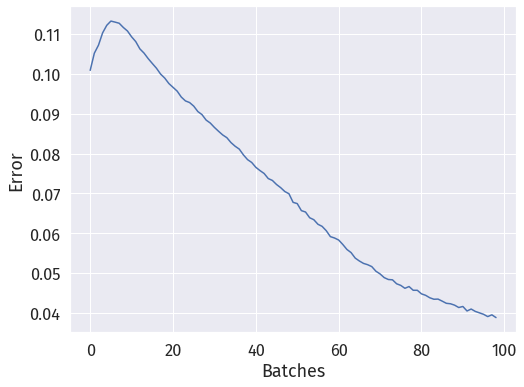

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
chart = sns.lineplot(meanError, ax=ax)
ax.set_ylabel("Error")
ax.set_xlabel("Batches")
plt.show()

## Step 4: Test Network

In [16]:
for i in range((nTrain + 1), nTot):
    activity = nn.forward_pass(p.nLayers, X, i)

    # store error
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

isTest = np.zeros(nTot, dtype=bool)
isTest[nTrain + 1 :] = True

In [17]:
activity

[array([0.55207371, 0.11697632]),
 array([0.45907116, 0.62604129, 0.7144875 , 0.44274218, 0.45389642,
        0.4363493 , 0.47812196, 0.55390275, 0.67104279, 0.63612016,
        0.719648  , 0.4146179 , 0.55028062, 0.53268647, 0.45044264,
        0.31039143, 0.33464342, 0.78462543, 0.25454336, 0.73456892]),
 array([0.96441726, 0.84941787, 0.28769223, 0.7075087 , 0.29881608,
        0.80250532, 0.54558078, 0.19689754, 0.99013934, 0.97302508,
        0.10649909, 0.96058621, 0.40282965, 0.87250409, 0.97989924,
        0.04799413, 0.28301993, 0.40543082, 0.05311713, 0.06436982]),
 array([0.99459984, 0.53740316, 0.00402476, 0.98805721, 0.95507867,
        0.18016832, 0.01260673, 0.00379362, 0.27168109, 0.13223276,
        0.31195322, 0.80238268, 0.08505709, 0.00555701, 0.99588849,
        0.16365618, 0.00579882, 0.72126885, 0.8607884 , 0.98376633]),
 array([0.25292352])]

In [18]:
allError

array([-0.19313913, -0.19394939,  0.00529407, ..., -0.03221128,
       -0.03221128, -0.03221128])

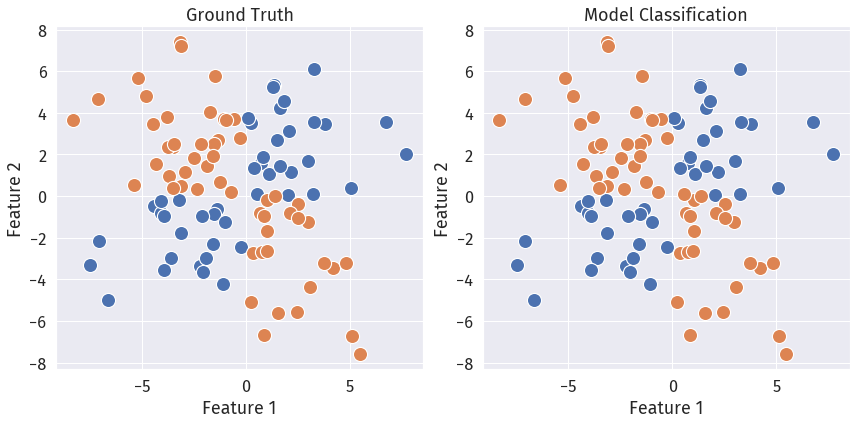

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Ground Truth")
sns.scatterplot(
    x=X[(Y == 1) & isTest, 0],
    y=X[(Y == 1) & isTest, 1],
    s=200,
    ax=ax[0],
)
sns.scatterplot(
    x=X[(Y == 0) & isTest, 0],
    y=X[(Y == 0) & isTest, 1],
    s=200,
    ax=ax[0],
)
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")


ax[1].set_title("Model Classification")
sns.scatterplot(
    x=X[(catPredict == 1) & isTest, 0],
    y=X[(catPredict == 1) & isTest, 1],
    s=200,
    ax=ax[1],
)
sns.scatterplot(
    x=X[(catPredict == 0) & isTest, 0],
    y=X[(catPredict == 0) & isTest, 1],
    s=200,
    ax=ax[1],
)
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")

fig.tight_layout()
plt.show()